In [8]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

In [4]:
experiments_metrics = {}
experiments_root = '/workspace/RawData/FCDNet/logs/features_comparison/t1'

metrics = ['val_dice_score_epoch']

for trial, experiment_name in tqdm(enumerate(os.listdir(experiments_root))):
    experiment_path = os.path.join(experiments_root, experiment_name)
    tb_path = os.path.join(experiment_path, 'tb')
    event_name = os.listdir(tb_path)[0]
    event_path = os.path.join(tb_path, event_name) # take an event file 
    ea = event_accumulator.EventAccumulator(event_path, 
                                            size_guidance={ 
                                                            event_accumulator.COMPRESSED_HISTOGRAMS: 0,
                                                            event_accumulator.IMAGES: 0,
                                                            event_accumulator.AUDIO: 0,
                                                            event_accumulator.SCALARS: 10**8,
                                                            event_accumulator.HISTOGRAMS: 0,
                                                           }
                                            )

    ea.Reload()
    
    metrics_dict = {}
    for metric_name in metrics:
        metrics_dict[metric_name] = [event.value for event in ea.Scalars(metric_name)]
        
    experiments_metrics[trial] = metrics_dict


3it [00:00, 10.43it/s]


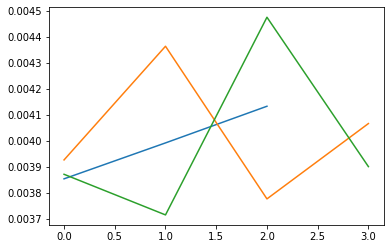

In [9]:
metric_to_vis = 'val_dice_score_epoch'
for k,v in experiments_metrics.items():
    plt.plot(v[metric_to_vis], label=k)